# Plot our own size-stellar mass relation & compare with van der Wel+2014

In [1]:
import numpy as np
import pandas as pd
import catalogs as rc
import plot_Rvir_Reff as prr
import mass_size as ms
import mass_stellar2halo as msh
import uvj
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
from matplotlib.ticker import MultipleLocator, FixedLocator
from mpl_toolkits.axes_grid1 import ImageGrid
from statsmodels.nonparametric.smoothers_lowess import lowess as LOWESS
from statsmodels.robust.scale import mad as MAD
from scipy.stats import binned_statistic
from astropy.cosmology import FlatLambdaCDM
%matplotlib inline
cosmo0 = prr.cosmo0
print(cosmo0)
cosmo_vdw14 = FlatLambdaCDM(H0=71., Om0=0.27)
print(cosmo_vdw14)

# Customize line styles
dashed = [12, 3, 12, 3]
dashdot = [3, 3, 8, 3]
dotted = [3, 3]

FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.27, Tcmb0=2.725 K, Neff=3.04, m_nu=[ 0.  0.  0.] eV, Ob0=None)
FlatLambdaCDM(H0=71 km / (Mpc s), Om0=0.27, Tcmb0=2.725 K, Neff=3.04, m_nu=[ 0.  0.  0.] eV, Ob0=None)


### Read the catalog for plotting & vdw14 Table 2 (which they show in Fig. 8)

In [2]:
df = pd.read_csv('candels_rr_plots.cat')
rm_early = pd.read_csv('vdw14_fig8_early.csv')
rm_late = pd.read_csv('vdw14_fig8_late.csv')
df.columns

Index([u'agnflag', u'dec_gfit_h', u'dec_gfit_j', u'decdeg', u'deep_flag',
       u'dmag_h', u'dmag_j', u'dn_h', u'dn_j', u'dpa_h', u'dpa_j', u'dq_h',
       u'dq_j', u'dre_h', u'dre_j', u'f_h', u'f_j', u'field', u'flux_radius_2',
       u'hmag', u'id', u'logsfr_med', u'logssfr_med', u'm200c_b13',
       u'm200c_k13', u'm200c_r15', u'm200c_t14', u'm200c_vmax', u'm_halo_h15',
       u'm_halo_m16', u'm_med', u'mag_h', u'mag_j', u'mvir_b13', u'n_h',
       u'n_j', u'pa_h', u'pa_j', u'photflag', u'q_h', u'q_j', u'q_zspec',
       u'r200c_kpc_d10', u'r200c_kpc_h15', u'r200c_kpc_k13', u'r200c_kpc_m16',
       u'r200c_kpc_r15', u'r200c_kpc_t14', u'r200c_kpc_vmax',
       u'r200c_m200c_kpc_b13', u'r200c_mvir_kpc_b13', u'r_eff_vrest_kpc',
       u'ra_gfit_h', u'ra_gfit_j', u'radeg', u're_h', u're_j', u'restj2mass',
       u'restujohnson', u'restvjohnson', u's_med', u'sersic_n', u'sn_h',
       u'sn_j', u'udf_flag', u'zbest', u'zspec'],
      dtype='object')

In [3]:
np.sort(df['sersic_n'])

array([ 0.2001,  0.2009,  0.2012, ...,  7.9998,  7.9999,  7.9999])

### If we want to compare directly with vdw14, we should also do UVJ selection

#### Compute our median size-mass relations for UVJ selection in each redshift bin

In [3]:
zbins = np.arange(0., 3., 0.5)
rm_early_ours = {}
mad_early_ours = {}
upper_early_ours = {}
lower_early_ours = {}
rm_late_ours = {}
mad_late_ours = {}
upper_late_ours = {}
lower_late_ours = {}
numbers_late = {}
numbers_early = {}
logM_bins = np.arange(7., 12.1, 0.5)
logRvir_bins = {}
red_frac = np.zeros(len(zbins))
for i in range(len(zbins)):
    z0 = zbins[i]
    z1 = z0 + 0.5
    zm = (z0 + z1) / 2.
    zstr = '%.1f' % z0
    c_bin = df[(df.zbest >= z0) & (df.zbest < z1)]
    sersic_n = np.sort(c_bin['sersic_n'])
    n_10pc = int(round(len(sersic_n) * 0.1))
    n_low = sersic_n[n_10pc]
    n_high = sersic_n[-n_10pc]
    red = (c_bin['sersic_n'].values >= n_high)
    blue = (c_bin['sersic_n'].values <= n_low)
#     red_frac[i] = float(red.sum()) / float(len(c_bin))
    logMvir = np.array(list(map(msh.calc_halo_mass_t14, logM_bins+0.25, [zm] * len(logM_bins))))
    logRvir_bins[zstr] = np.log10(np.array(list(map(lambda logm: ms.R200(10.**logm, zm), logMvir))))
    logM_star_late = c_bin['m_med'].values[blue]
    logReff_late = np.log10(c_bin['r_eff_vrest_kpc'].values[blue])
    logM_star_early = c_bin['m_med'].values[red]
    logReff_early = np.log10(c_bin['r_eff_vrest_kpc'].values[red])
    numbers_late[zstr] = np.histogram(c_bin['m_med'].values[blue], bins=logM_bins)[0]
    numbers_early[zstr] = np.histogram(c_bin['m_med'].values[red], bins=logM_bins)[0]
    l_late = binned_statistic(logM_star_late, logReff_late, bins=logM_bins, statistic=np.median)
    l_early = binned_statistic(logM_star_early, logReff_early, bins=logM_bins, statistic=np.median)
    mad_late = binned_statistic(logM_star_late, logReff_late, bins=logM_bins, statistic=MAD)
    mad_early = binned_statistic(logM_star_early, logReff_early, bins=logM_bins, statistic=MAD)
    upper_late = binned_statistic(logM_star_late, logReff_late, bins=logM_bins, statistic=lambda x: np.percentile(x, 84))
    upper_early = binned_statistic(logM_star_early, logReff_early, bins=logM_bins, statistic=lambda x: np.percentile(x, 84))
    lower_late = binned_statistic(logM_star_late, logReff_late, bins=logM_bins, statistic=lambda x: np.percentile(x, 16))
    lower_early = binned_statistic(logM_star_early, logReff_early, bins=logM_bins, statistic=lambda x: np.percentile(x, 16))
    rm_late_ours[zstr] = l_late[0]
    rm_early_ours[zstr] = l_early[0]
    mad_late_ours[zstr] = mad_late[0]
    mad_early_ours[zstr] = mad_early[0]
    upper_late_ours[zstr] = upper_late[0]
    upper_early_ours[zstr] = upper_early[0]
    lower_late_ours[zstr] = lower_late[0]
    lower_early_ours[zstr] = lower_early[0]

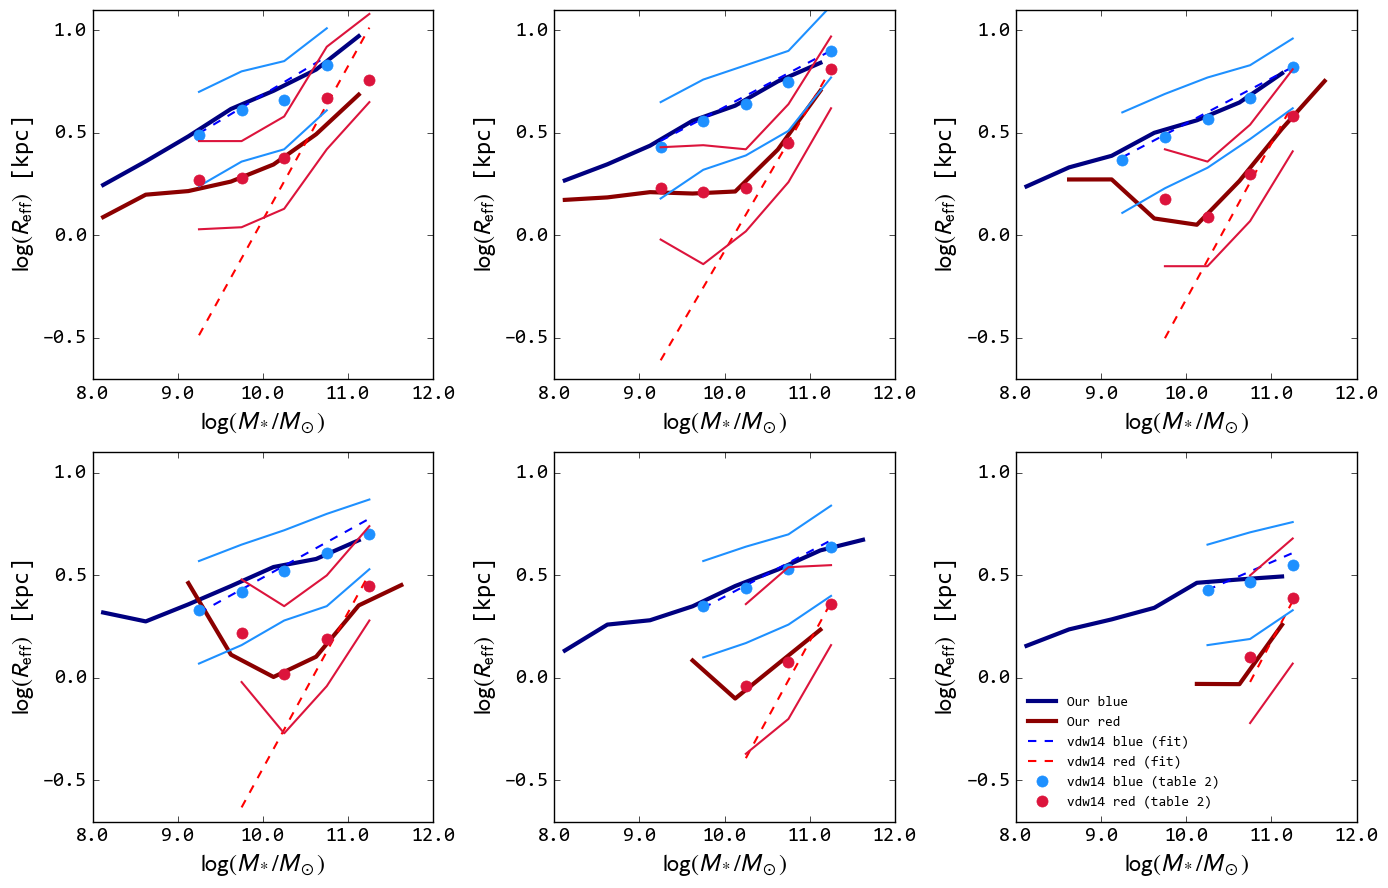

In [4]:
fig1 = plt.figure(figsize=(14, 9))
for i in range(len(zbins)):
    z0 = zbins[i]
    z1 = zbins[i] + 0.5
    zm = (z0 + z1) / 2.
    zstr = '%.1f' % z0
    ax = fig1.add_subplot(2, 3, i+1)
    ax.plot(logM_bins[:-1] + 0.125, rm_late_ours[zstr], c='Navy', lw=3, label='Our blue')
    ax.plot(logM_bins[:-1] + 0.125, rm_early_ours[zstr], c='DarkRed', lw=3, label='Our red')
    # Add fitted vdw14 relations
    logM_vdw_b, logr_eff_vdw_b = ms.mass_size_vdw14(zm, 'blue')
    logM_vdw_r, logr_eff_vdw_r = ms.mass_size_vdw14(zm, 'red')
    ax.plot(logM_vdw_b, logr_eff_vdw_b, lw=1.5, ls='--', c='blue', label='vdw14 blue (fit)')
    ax.plot(logM_vdw_r, logr_eff_vdw_r, lw=1.5, ls='--', c='red', label='vdw14 red (fit)')
    # Add tabulated vdw14 relations
    ax.plot(rm_late['logM'], rm_late[zstr+'_med'], ls='none', marker='.', ms=16, color='DodgerBlue',
           label='vdw14 blue (table 2)')
    ax.plot(rm_late['logM'], rm_late[zstr+'_hi'], ls='-', marker='', lw=1.5, color='DodgerBlue',
           label='')
    ax.plot(rm_late['logM'], rm_late[zstr+'_lo'], ls='-', marker='', lw=1.5, color='DodgerBlue',
           label='')
    ax.plot(rm_early['logM'], rm_early[zstr+'_med'], ls='none', marker='.', ms=16, color='Crimson',
           label='vdw14 red (table 2)')
    ax.plot(rm_early['logM'], rm_early[zstr+'_hi'], ls='-', marker='', lw=1.5, color='Crimson',
           label='')
    ax.plot(rm_early['logM'], rm_early[zstr+'_lo'], ls='-', marker='', lw=1.5, color='Crimson',
           label='')
    
    ax.set_xlim(8, 12)
    ax.set_ylim(-0.7, 1.1)
    ax.set_xticks(np.arange(8, 12.1, 1))
    ax.set_xticklabels(['%.1f' % x for x in np.arange(8, 12.1, 1.)])
    ax.set_xlabel(r'$\log(M_*/M_\odot)$', size='xx-large')
    ax.set_ylabel(r'$\log(R_{\rm{eff}})$ [kpc]', size='xx-large')
    if i == 5:
        ax.legend(loc=3, fontsize='medium', frameon=False)
    
plt.tight_layout()
fig1.savefig('RM_compare_vdw14.png')

Median redshift for 0.0 < z < 0.5 is 0.34
Median redshift for 0.5 < z < 1.0 is 0.73
Median redshift for 1.0 < z < 1.5 is 1.23
Median redshift for 1.5 < z < 2.0 is 1.70
Median redshift for 2.0 < z < 2.5 is 2.23
Median redshift for 2.5 < z < 3.0 is 2.69


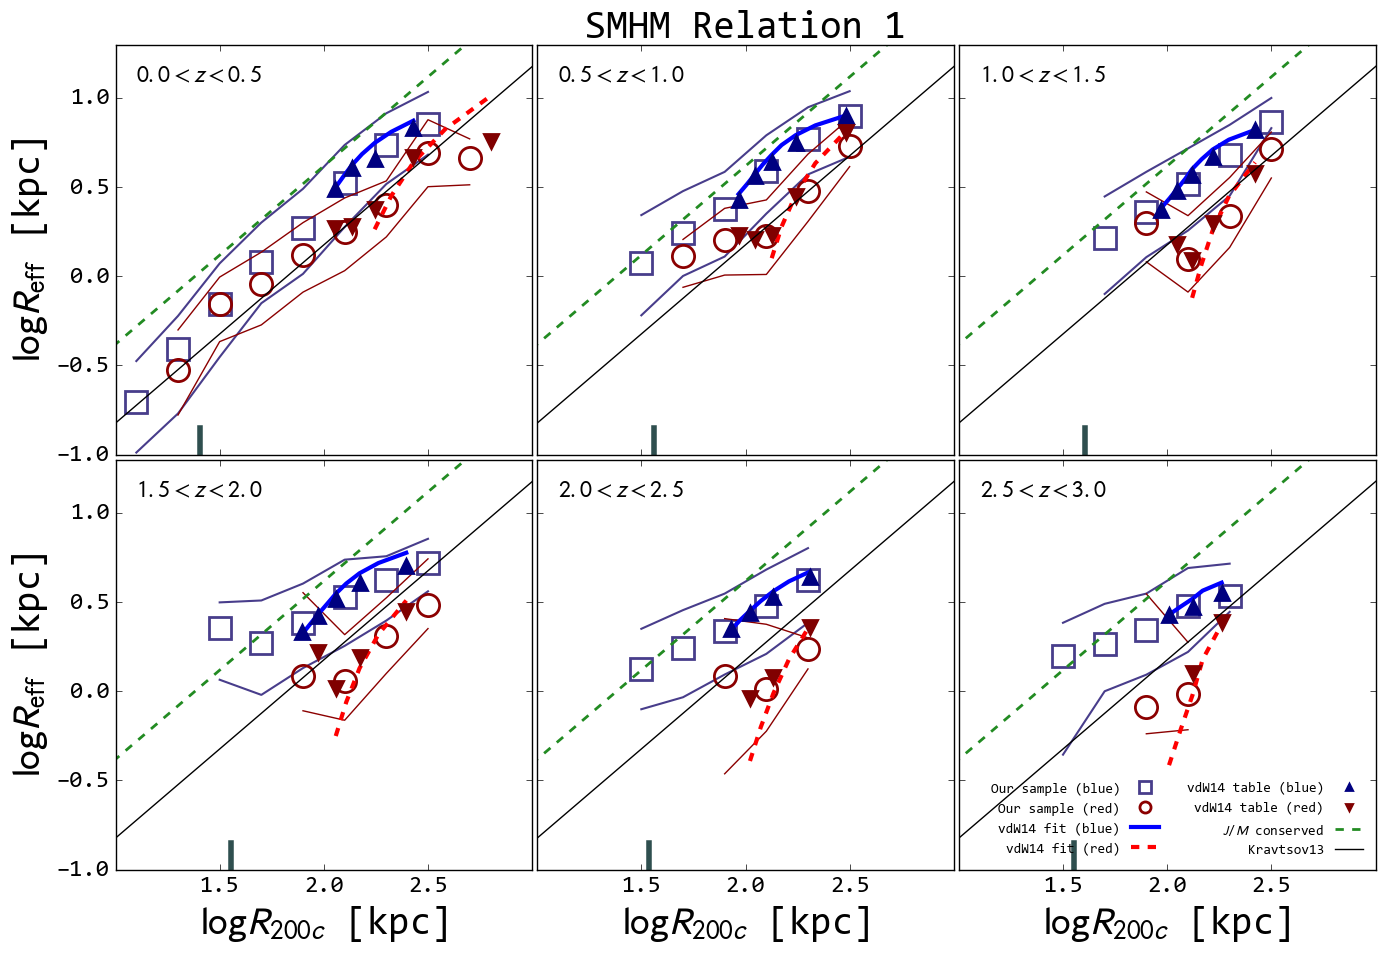

In [4]:
reload(prr)
fig2, grid2 = prr.plot_rr_allz(df, alpha_scatter=-1, cut_by='uvj', conversion='t14', add_vdw14_fit=True,
                              add_vdw14_tab=True, filename='ms/RR_T14_uvj3.pdf')

### Convert our median size-mass relation onto Reff vs. Rvir diagram

In [1]:
reload(prr)
fig3, grid3 = prr.plot_rr_allz(df, alpha_scatter=-1, cut_by='uvj', conversion='t14')
for i in range(6):
    z0 = zbins[i]
    zm = z0 + 0.25
    zstr = '%.1f' % z0
    func_late, func_early = prr.func_smhm('t14', zm)
    logM200c_late = np.array(list(map(func_late, logM_bins+0.125)))
    logR200c_late = np.log10(ms.R200(10.**logM200c_late, zm, cosmo=cosmo0))
    logM200c_early = np.array(list(map(func_early, logM_bins+0.125)))
    logR200c_early = np.log10(ms.R200(10.**logM200c_early, zm, cosmo=cosmo0))
    grid3[i].plot(logR200c_late[:-1], rm_late_ours[zstr], lw=2, c='DodgerBlue', label='Blue (from RM reln)')
    grid3[i].plot(logR200c_early[:-1], rm_early_ours[zstr], lw=2, c='Crimson', label='Red (from RM reln)')
    if i == 5:
        grid3[i].legend(loc=4, fontsize='medium', frameon=False)
fig3.savefig('ms/RR_T14_from_RM.png')

NameError: name 'prr' is not defined

### Plot galaxy size--stellar mass and compare our sample with vdw+14

N_red, N_blue = 1072, 1074
alpha_blue, alpha_red = 8.18e-02, 1.83e-01
N_red, N_blue = 2451, 2452
alpha_blue, alpha_red = 3.58e-02, 8.00e-02
N_red, N_blue = 1635, 1636
alpha_blue, alpha_red = 5.37e-02, 1.20e-01
N_red, N_blue = 1293, 1294
alpha_blue, alpha_red = 6.78e-02, 1.52e-01
N_red, N_blue = 671, 672
alpha_blue, alpha_red = 1.31e-01, 2.92e-01
N_red, N_blue = 407, 408
alpha_blue, alpha_red = 2.16e-01, 4.82e-01


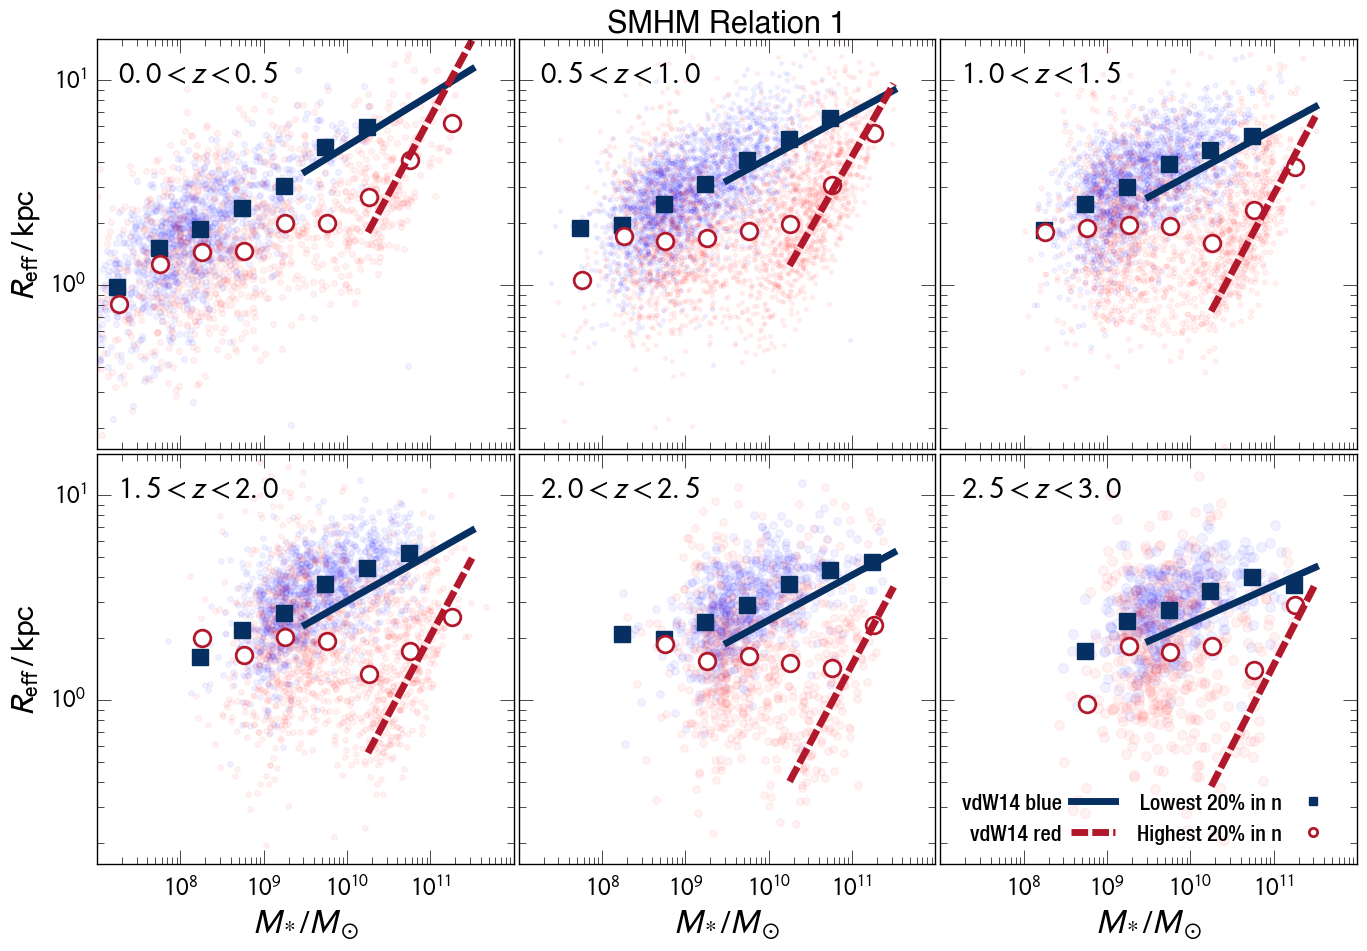

In [7]:
fig4 = plt.figure(figsize=(14, 11))
grid = ImageGrid(fig4, (0.08, 0.15, 0.9, 0.75),
                     nrows_ncols=(2, 3),
                     axes_pad=0.05,
                     share_all=True,
                     aspect=False,
                     label_mode='L')

cut_by, include = ['sersic', 'n_20pc']
alpha_scatter = 0.05

xticks_major = FixedLocator([7., 8., 9., 10., 11., 12.])
xticks_minor = []
for x in np.arange(7., 12.1, 1.):
    xticks_minor = np.concatenate([xticks_minor,
                                   np.log10(np.arange(2*np.power(10, x), 9.9*np.power(10, x), np.power(10, x)))])
xticks_minor = FixedLocator(xticks_minor)
yticks_major = FixedLocator([0., 1.])
yticks_minor = FixedLocator(np.concatenate(
                            [np.log10(np.arange(0.2, 0.99, 0.1)),
                            np.log10(np.arange(2., 9.9, 1.))]))

zbins = np.arange(0., 3., 0.5)
n_zbins = np.histogram(df.zbest.values, bins=np.arange(0., 3.1, 0.5))[0]
n_max_zbins = np.max(n_zbins)
for i in range(len(zbins)):
    z0 = zbins[i]
    z1 = zbins[i] + 0.5
    zm = (z0 + z1) / 2.
    zstr = '%.1f' % z0
    c_bin = df[(df.zbest >= z0) & (df.zbest < z1)]
    sersic_n_sorted = np.sort(c_bin['sersic_n'])
    ssfr_sorted = np.sort(c_bin['logssfr_med'])
    n_10pc = int(round(len(c_bin) * 0.1))
    n_15pc = int(round(len(c_bin) * 0.15))
    n_20pc = int(round(len(c_bin) * 0.2))
    if cut_by == 'sersic':
        if include == 'all':
            n_low = 2.5
            n_high = 2.5
            label_red = 'n > 2.5'
            label_blue = 'n < 2.5'
        elif include == 'n_10pc':
            n_low = sersic_n_sorted[n_10pc]
            n_high = sersic_n_sorted[-n_10pc]
            label_red = 'Highest 10% in n'
            label_blue = 'Lowest 10% in n'
        elif include == 'n_15pc':
            n_low = sersic_n_sorted[n_15pc]
            n_high = sersic_n_sorted[-n_15pc]
            label_red = 'Highest 15% in n'
            label_blue = 'Lowest 15% in n'
        elif include == 'n_20pc':
            n_low = sersic_n_sorted[n_20pc]
            n_high = sersic_n_sorted[-n_20pc]
            label_red = 'Highest 20% in n'
            label_blue = 'Lowest 20% in n'
        red = (c_bin['sersic_n'].values >= n_high)
        blue = (c_bin['sersic_n'].values <= n_low)
    elif cut_by == 'ssfr':
        if include == 'n_10pc':
            ssfr_low = ssfr_sorted[n_10pc]
            ssfr_high = ssfr_sorted[-n_10pc]
            label_red = 'Lowest 10% in sSFR'
            label_blue = 'Highest 10% in sSFR'
        elif include == 'n_15pc':
            ssfr_low = ssfr_sorted[n_15pc]
            ssfr_high = ssfr_sorted[-n_15pc]
            label_red = 'Lowest 15% in sSFR'
            label_blue = 'Highest 15% in sSFR'
        elif include == 'n_20pc':
            ssfr_low = ssfr_sorted[n_20pc]
            ssfr_high = ssfr_sorted[-n_20pc]
            label_red = 'Lowest 20% in sSFR'
            label_blue = 'Highest 20% in sSFR'
        red = (c_bin['logssfr_med'].values <= ssfr_low)
        blue = (c_bin['logssfr_med'].values >= ssfr_high)
    elif cut_by == 'uvj':
        red = uvj.select_uvj_red(c_bin, zm)
        blue = np.logical_not(red)
        label_red = 'UVJ Red'
        label_blue = 'UVJ Blue'
    
    print("N_red, N_blue = {}, {}".format(np.sum(red), np.sum(blue)))
    n_red = np.sum(red)
    n_blue = len(blue)
    ax = grid[i]
    
    # First, plot individual points
    alpha_red = np.minimum(0.08 * n_max_zbins / len(c_bin), 1.0)
#     alpha_blue = alpha_red
    alpha_blue = alpha_red * np.sqrt((float(n_red) / float(n_blue)))
    print("alpha_blue, alpha_red = {:.2e}, {:.2e}".format(alpha_blue, alpha_red))
    
    ms_bin = 8.0 * n_max_zbins / len(c_bin)
    
    logReff_med_blue = binned_statistic(c_bin['m_med'].values[blue],
                                       np.log10(c_bin['r_eff_vrest_kpc'].values[blue]),
                                       statistic=np.median, bins=logM_bins)[0]
    numbers_blue = np.histogram(c_bin['m_med'].values[blue], bins=logM_bins)[0]
    logReff_med_red = binned_statistic(c_bin['m_med'].values[red],
                                       np.log10(c_bin['r_eff_vrest_kpc'].values[red]),
                                       statistic=np.median, bins=logM_bins)[0]
    numbers_red = np.histogram(c_bin['m_med'].values[red], bins=logM_bins)[0]
    
    show_blue = (numbers_blue >= 5)
    show_red = (numbers_red >= 5)
    ax.scatter(c_bin['m_med'].values[blue],
               np.log10(c_bin['r_eff_vrest_kpc']).values[blue],
               marker='o', edgecolor='blue', facecolor='blue', s=ms_bin,
               alpha=alpha_scatter)
    ax.scatter(c_bin['m_med'].values[red],
               np.log10(c_bin['r_eff_vrest_kpc']).values[red],
               marker='o', edgecolor='red', facecolor='red', s=ms_bin,
               alpha=alpha_scatter)
    
#     err_upper_late = upper_late_ours[zstr] - rm_late_ours[zstr]
#     err_lower_late = rm_late_ours[zstr] - lower_late_ours[zstr]
    ax.errorbar(logM_bins[:-1][show_blue]+0.25-0.01,
                logReff_med_blue[show_blue],
#                yerr=[err_lower_late[show_blue], err_upper_late[show_blue]],
               fmt='s', mec=prr.BLUE, mfc=prr.BLUE, elinewidth=2,
               ecolor=prr.BLUE, ms=12, mew=1, label=label_blue)
    
    err_upper_early = upper_early_ours[zstr] - rm_early_ours[zstr]
    err_lower_early = rm_early_ours[zstr] - lower_early_ours[zstr]
    ax.errorbar(logM_bins[:-1][show_red]+0.25+0.01,
                logReff_med_red[show_red],
#                 yerr=[err_lower_early[show_red], err_upper_early[show_red]],
                fmt='o', mec=prr.RED, mfc='white',
                linewidth=2, ms=12, mew=2, elinewidth=2,
                ecolor=prr.RED, label=label_red)
    
    # Now add the power-law fits
    DA0 = cosmo0.angular_diameter_distance(zm).value
    DL0 = cosmo0.luminosity_distance(zm).value
    DA_vdw14 = cosmo_vdw14.angular_diameter_distance(zm).value
    DL_vdw14 = cosmo_vdw14.luminosity_distance(zm).value
    # a small correction factor for physical size due to different assumed cosmology
    log_DAcorr = np.log10(DA_vdw14) - np.log10(DA0)
    # a small correction factor for stellar mass due to differences in luminosity distance
    log_DL2corr = 2 * (np.log10(DL_vdw14) - np.log10(DL0))
    logM_vdw_b, logr_eff_vdw_b = ms.mass_size_vdw14(zm, 'blue')
    logM_vdw_r, logr_eff_vdw_r = ms.mass_size_vdw14(zm, 'red')
    l1, = ax.plot(logM_vdw_b, logr_eff_vdw_b + log_DAcorr, lw=5, ls='-',
            c=prr.BLUE, label='vdW14 blue')
    l2, = ax.plot(logM_vdw_r, logr_eff_vdw_r + log_DAcorr, lw=5, ls='--',
            c=prr.RED, label='vdW14 red')
    l2.set_dashes(dashed)
    
    if i == 1:
        ax.set_title('SMHM Relation 1', size=22)
#     ax.set_xticks(np.arange(8, 11.1, 1.))
#     ax.set_yticks(np.arange(-0.5, 1.2, 0.5))
#     ax.set_xticklabels(['%d' % int(x) for x in ax.get_xticks()], size='xx-large')
#     ax.set_yticklabels(['%.1f' % float(y) for y in ax.get_yticks()], size='xx-large')
    ax.xaxis.set_major_locator(xticks_major)
    ax.set_xticklabels(['', r'$10^8$', r'$10^9$', r'$10^{10}$', r'$10^{11}$', ''])
    ax.xaxis.set_minor_locator(xticks_minor)
    ax.yaxis.set_major_locator(yticks_major)
    ax.yaxis.set_minor_locator(yticks_minor)
    ax.set_yticklabels([r'$10^0$', r'$10^1$'])
    ax.tick_params(which='major', length=10, pad=8,
                            labelsize=18)
    ax.tick_params(which='minor', length=5)
    ax.set_xlim(7, 12)
    ax.set_ylim(-0.8, 1.2)
    ax.text(0.05, 0.95, r'${:.1f} < z < {:.1f}$'.format(z0, z1), transform=ax.transAxes,
           size=22, ha='left', va='top')
    ax.set_xlabel(r'$M_*/M_\odot$', size=24)
    ax.set_ylabel(r'$R_{\rm{eff}}\,/\,\rm{kpc}$', size=24)
#     ax.set_xlabel(r'$\log(M_*/M_\odot)$', size=24)
#     ax.set_ylabel(r'$\log(R_{\rm{eff}}\,/\,\rm{kpc})$', size=24)
    if i == 5:
        helvet_cond = '/Users/khuang/Dropbox/downloaded_fonts/helvetica_neue/HelveticaNeueLTStd-MdCn.otf'
        prop = fm.FontProperties(fname=helvet_cond, size=16)
        ax.legend(loc='lower center', frameon=False, prop=prop, ncol=2, markerscale=0.5,
                 markerfirst=False, handletextpad=0.4, columnspacing=1.0)
    
fig4.savefig('ms/RM_T14_sersic_20pc_vdw.pdf')

Median redshift for 0.0 < z < 0.5 is 0.35
n_blue, n_red = 4550, 834
alpha_blue, alpha_red = 0.09, 0.20
Median redshift for 0.5 < z < 1.0 is 0.73
n_blue, n_red = 10819, 1496
alpha_blue, alpha_red = 0.04, 0.10
Median redshift for 1.0 < z < 1.5 is 1.23
n_blue, n_red = 7697, 526
alpha_blue, alpha_red = 0.03, 0.10
Median redshift for 1.5 < z < 2.0 is 1.70
n_blue, n_red = 6111, 385
alpha_blue, alpha_red = 0.03, 0.10
Median redshift for 2.0 < z < 2.5 is 2.23
n_blue, n_red = 3174, 186
alpha_blue, alpha_red = 0.07, 0.30
Median redshift for 2.5 < z < 3.0 is 2.69
n_blue, n_red = 1990, 55
alpha_blue, alpha_red = 0.10, 0.60


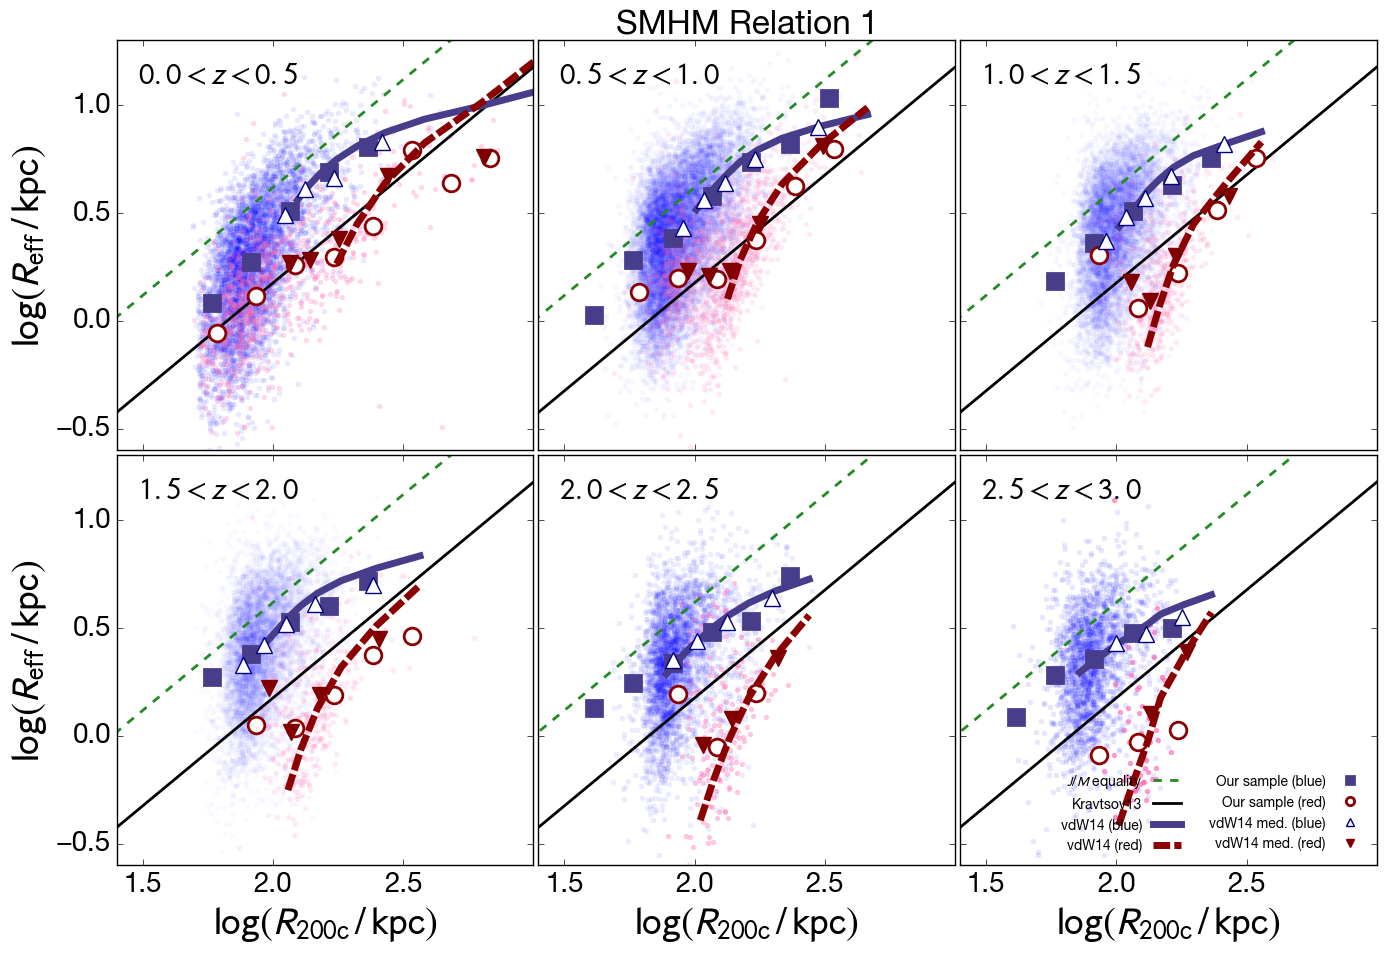

In [6]:
reload(prr)
fig5, grid5 = prr.plot_rr_allz(df, alpha_scatter=0.1, cut_by='uvj', conversion='t14', add_vdw14_fit=True,
                              add_vdw14_tab=True, filename='ms/RR_T14_uvj_vdw.pdf')

### Use our own bins

Median redshift for 0.0 < z < 0.5 is 0.35
('n_20pc = ', 1072)
n_low, n_high = 0.82, 1.84
n_blue, n_red = 1072, 1071
alpha_blue, alpha_red = 0.10, 0.10
Median redshift for 0.5 < z < 1.0 is 0.73
('n_20pc = ', 2451)
n_low, n_high = 0.77, 2.07
n_blue, n_red = 2451, 2450
alpha_blue, alpha_red = 0.05, 0.05
Median redshift for 1.0 < z < 1.5 is 1.23
('n_20pc = ', 1635)
n_low, n_high = 0.68, 2.14
n_blue, n_red = 1635, 1634
alpha_blue, alpha_red = 0.05, 0.05
Median redshift for 1.5 < z < 2.0 is 1.70
('n_20pc = ', 1293)
n_low, n_high = 0.69, 2.37
n_blue, n_red = 1293, 1292
alpha_blue, alpha_red = 0.05, 0.05
Median redshift for 2.0 < z < 2.5 is 2.23
('n_20pc = ', 671)
n_low, n_high = 0.68, 2.42
n_blue, n_red = 671, 670
alpha_blue, alpha_red = 0.15, 0.15
Median redshift for 2.5 < z < 3.0 is 2.69
('n_20pc = ', 407)
n_low, n_high = 0.69, 2.45
n_blue, n_red = 407, 406
alpha_blue, alpha_red = 0.30, 0.30


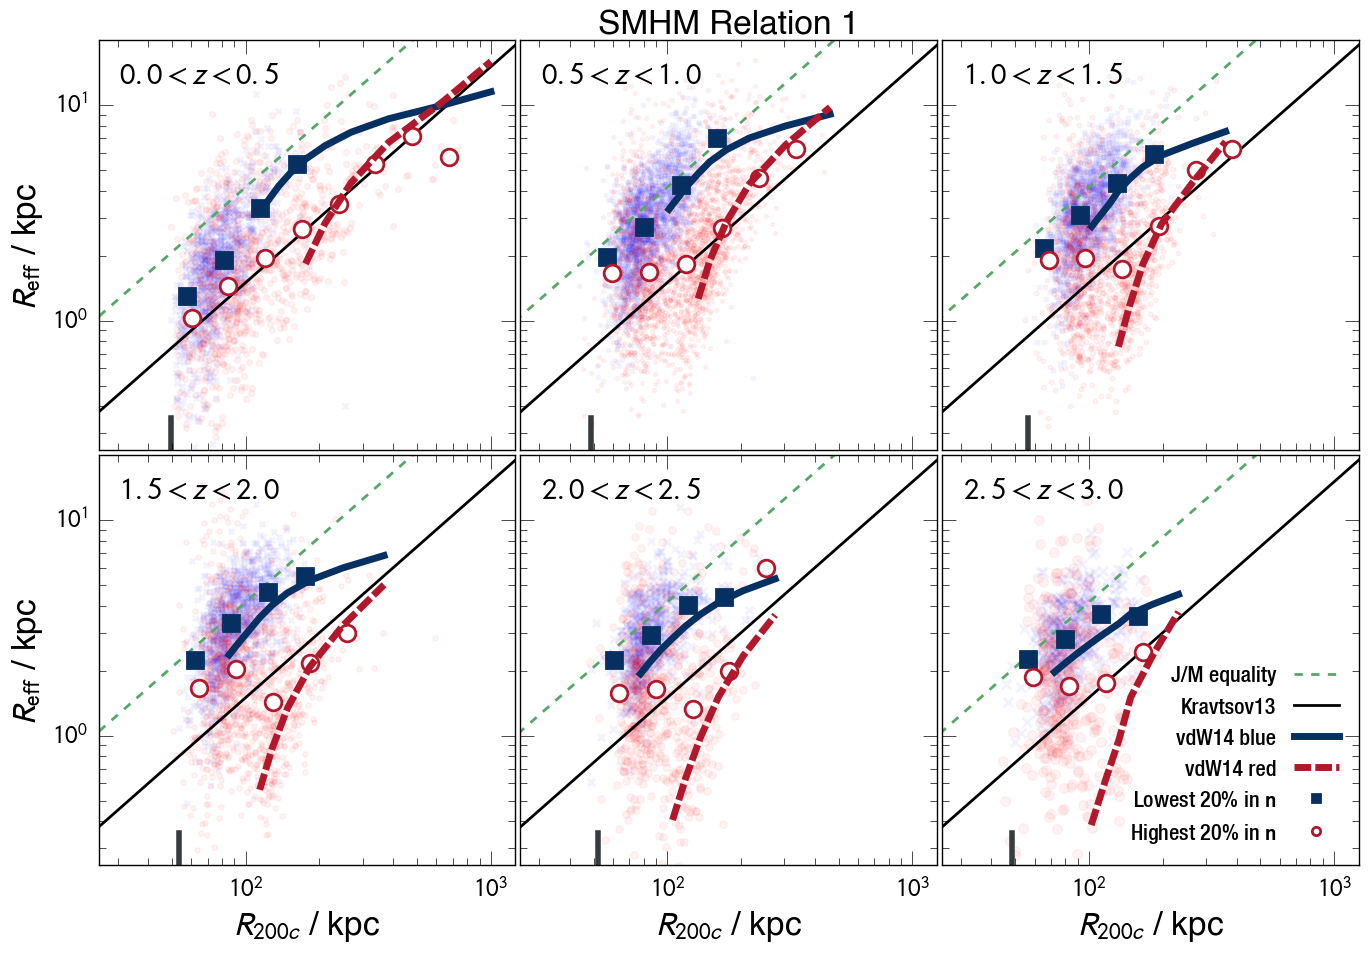

In [8]:
reload(prr)
fig6, grid6 = prr.plot_rr_allz(df, cut_by='sersic', include='n_20pc', conversion='t14', add_vdw14_fit=True,
                              filename='ms/RR_T14_sersic_20pc_vdw.pdf', alpha_scatter=0.05,
                              errorbars=False, legend_fontsize=16, legend_ncols=1)

### Directly convert binned medians onto the Reff-Rvir diagram

N_red, N_blue = 875, 4824
alpha_blue, alpha_red = 3.39e-02, 8.64e-02
N_red, N_blue = 1496, 10819
alpha_blue, alpha_red = 1.39e-02, 4.00e-02
N_red, N_blue = 526, 7697
alpha_blue, alpha_red = 1.52e-02, 5.99e-02


/Users/khuang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 11 but corresponding boolean dimension is 10
/Users/khuang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:115: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 11 but corresponding boolean dimension is 10
/Users/khuang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 11 but corresponding boolean dimension is 10
/Users/khuang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:115: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 11 but corresponding boolean dimension is 10
/Users/khuang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning:

N_red, N_blue = 385, 6111
alpha_blue, alpha_red = 1.85e-02, 7.58e-02
N_red, N_blue = 186, 3174
alpha_blue, alpha_red = 3.45e-02, 1.47e-01
N_red, N_blue = 55, 1990
alpha_blue, alpha_red = 3.95e-02, 2.41e-01


/Users/khuang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 11 but corresponding boolean dimension is 10
/Users/khuang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:115: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 11 but corresponding boolean dimension is 10
/Users/khuang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 11 but corresponding boolean dimension is 10
/Users/khuang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:115: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 11 but corresponding boolean dimension is 10
/Users/khuang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning:

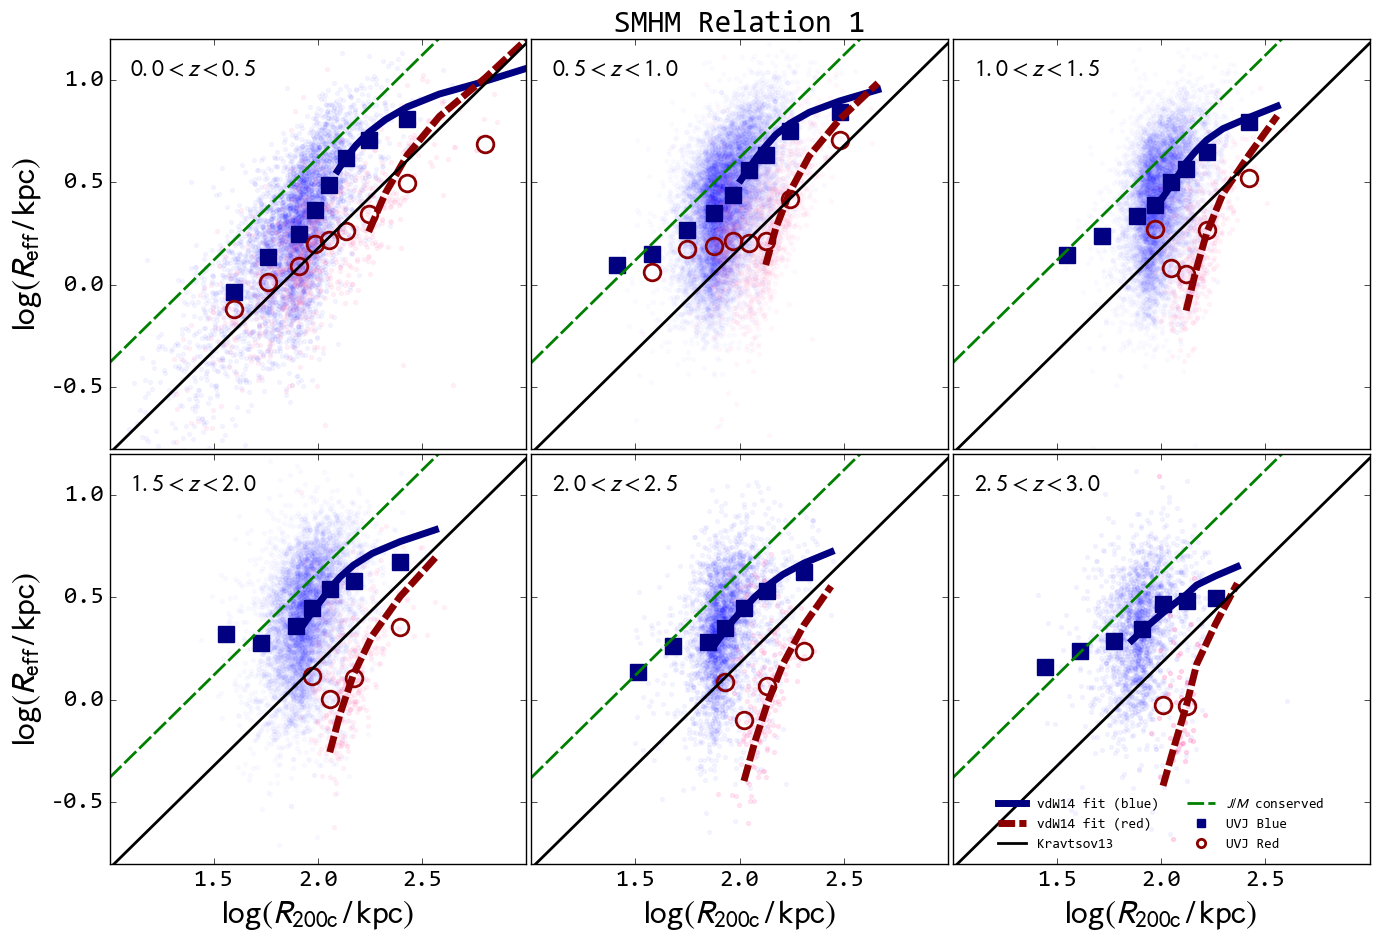

In [8]:
fig6 = plt.figure(figsize=(14, 11))
grid = ImageGrid(fig6, (0.08, 0.15, 0.9, 0.75),
                     nrows_ncols=(2, 3),
                     axes_pad=0.05,
                     share_all=True,
                     aspect=False,
                     label_mode='L')

cut_by, include = ['uvj', 'n_15pc']

zbins = np.arange(0., 3., 0.5)
n_zbins = np.histogram(df.zbest.values, bins=np.arange(0., 3.1, 0.5))[0]
n_max_zbins = np.max(n_zbins)
for i in range(len(zbins)):
    z0 = zbins[i]
    z1 = zbins[i] + 0.5
    zm = (z0 + z1) / 2.
    zstr = '%.1f' % z0
    c_bin = df[(df.zbest >= z0) & (df.zbest < z1)]
    sersic_n_sorted = np.sort(c_bin['sersic_n'])
    ssfr_sorted = np.sort(c_bin['logssfr_med'])
    n_10pc = int(round(len(c_bin) * 0.1))
    n_15pc = int(round(len(c_bin) * 0.15))
    n_20pc = int(round(len(c_bin) * 0.2))
    if cut_by == 'sersic':
        if include == 'all':
            n_low = 2.5
            n_high = 2.5
            label_red = 'n > 2.5'
            label_blue = 'n < 2.5'
        elif include == 'n_10pc':
            n_low = sersic_n_sorted[n_10pc]
            n_high = sersic_n_sorted[-n_10pc]
            label_red = 'Highest 10% in n'
            label_blue = 'Lowest 10% in n'
        elif include == 'n_15pc':
            n_low = sersic_n_sorted[n_15pc]
            n_high = sersic_n_sorted[-n_15pc]
            label_red = 'Highest 15% in n'
            label_blue = 'Lowest 15% in n'
        elif include == 'n_20pc':
            n_low = sersic_n_sorted[n_20pc]
            n_high = sersic_n_sorted[-n_20pc]
            label_red = 'Highest 20% in n'
            label_blue = 'Lowest 20% in n'
        red = (c_bin['sersic_n'].values >= n_high)
        blue = (c_bin['sersic_n'].values <= n_low)
    elif cut_by == 'ssfr':
        if include == 'n_10pc':
            ssfr_low = ssfr_sorted[n_10pc]
            ssfr_high = ssfr_sorted[-n_10pc]
            label_red = 'Lowest 10% in sSFR'
            label_blue = 'Highest 10% in sSFR'
        elif include == 'n_15pc':
            ssfr_low = ssfr_sorted[n_15pc]
            ssfr_high = ssfr_sorted[-n_15pc]
            label_red = 'Lowest 15% in sSFR'
            label_blue = 'Highest 15% in sSFR'
        elif include == 'n_20pc':
            ssfr_low = ssfr_sorted[n_20pc]
            ssfr_high = ssfr_sorted[-n_20pc]
            label_red = 'Lowest 20% in sSFR'
            label_blue = 'Highest 20% in sSFR'
        red = (c_bin['logssfr_med'].values <= ssfr_low)
        blue = (c_bin['logssfr_med'].values >= ssfr_high)
    elif cut_by == 'uvj':
        red = uvj.select_uvj_red(c_bin, zm)
        blue = np.logical_not(red)
        label_red = 'UVJ Red'
        label_blue = 'UVJ Blue'
    
    print("N_red, N_blue = {}, {}".format(np.sum(red), np.sum(blue)))
    n_red = np.sum(red)
    n_blue = len(blue)
    ax = grid[i]
    
    # First, plot individual points
    alpha_red = np.minimum(0.04 * n_max_zbins / len(c_bin), 1.0)
#     alpha_blue = alpha_red
    alpha_blue = alpha_red * np.sqrt((float(n_red) / float(n_blue)))
    print("alpha_blue, alpha_red = {:.2e}, {:.2e}".format(alpha_blue, alpha_red))
    
    logMvir = np.array(list(map(msh.calc_halo_mass_t14, logM_bins+0.25, [zm] * len(logM_bins))))
    logRvir_bins = np.log10(np.array(list(map(lambda logm: ms.R200(10.**logm, zm), logMvir))))
    
    logReff_med_blue = binned_statistic(c_bin['m_med'].values[blue],
                                       np.log10(c_bin['r_eff_vrest_kpc'].values[blue]),
                                       statistic=np.median, bins=logM_bins)[0]
    
    numbers_blue = np.histogram(c_bin['m_med'].values[blue], bins=logM_bins)[0]
    logReff_med_red = binned_statistic(c_bin['m_med'].values[red],
                                       np.log10(c_bin['r_eff_vrest_kpc'].values[red]),
                                       statistic=np.median, bins=logM_bins)[0]
    numbers_red = np.histogram(c_bin['m_med'].values[red], bins=logM_bins)[0]
    
    show_blue = (numbers_blue >= 5)
    show_red = (numbers_red >= 5)
    ax.scatter(np.log10(c_bin['r200c_kpc_t14']).values[blue],
               np.log10(c_bin['r_eff_vrest_kpc']).values[blue],
               marker='o', edgecolor='blue', facecolor='blue', s=8, alpha=alpha_blue)
    ax.scatter(np.log10(c_bin['r200c_kpc_t14']).values[red],
               np.log10(c_bin['r_eff_vrest_kpc']).values[red],
               marker='o', edgecolor='hotpink', facecolor='hotpink', s=8, alpha=alpha_red)
    
#     err_upper_late = upper_late_ours[zstr] - rm_late_ours[zstr]
#     err_lower_late = rm_late_ours[zstr] - lower_late_ours[zstr]
    ax.errorbar(logRvir_bins[show_blue],
                logReff_med_blue[show_blue],
#                yerr=[err_lower_late[show_blue], err_upper_late[show_blue]],
               fmt='s', mec='Navy', mfc='Navy', elinewidth=2,
               ecolor='Navy', ms=12, mew=1, label=label_blue)
    
    err_upper_early = upper_early_ours[zstr] - rm_early_ours[zstr]
    err_lower_early = rm_early_ours[zstr] - lower_early_ours[zstr]
    ax.errorbar(logRvir_bins[show_red],
                logReff_med_red[show_red],
#                 yerr=[err_lower_early[show_red], err_upper_early[show_red]],
                fmt='o', mec='DarkRed', mfc='none',
                linewidth=2, ms=12, mew=2, elinewidth=2,
                ecolor='DarkRed', label=label_red)
    
    # Now add the power-law fits
    DA0 = cosmo0.angular_diameter_distance(zm).value
    DL0 = cosmo0.luminosity_distance(zm).value
    DA_vdw14 = cosmo_vdw14.angular_diameter_distance(zm).value
    DL_vdw14 = cosmo_vdw14.luminosity_distance(zm).value
    # a small correction factor for physical size due to different assumed cosmology
    log_DAcorr = np.log10(DA_vdw14) - np.log10(DA0)
    # a small correction factor for stellar mass due to differences in luminosity distance
    log_DL2corr = 2 * (np.log10(DL_vdw14) - np.log10(DL0))
    logM_vdw_b, logr_eff_vdw_b = ms.mass_size_vdw14(zm, 'blue')
    logM_vdw_r, logr_eff_vdw_r = ms.mass_size_vdw14(zm, 'red')
    logM200c_vdw_b = np.array(list(map(lambda logm: msh.calc_halo_mass_t14(logm, zm), logM_vdw_b)))
    logR200c_vdw_b = np.log10(np.array(list(map(lambda logm: ms.R200(10.**logm, zm), logM200c_vdw_b))))
    logM200c_vdw_r = np.array(list(map(lambda logm: msh.calc_halo_mass_t14(logm, zm), logM_vdw_r)))
    logR200c_vdw_r = np.log10(np.array(list(map(lambda logm: ms.R200(10.**logm, zm), logM200c_vdw_r))))
               
    l1, = ax.plot(logR200c_vdw_b, logr_eff_vdw_b + log_DAcorr, lw=5, ls='-',
            c='Navy', label='vdW14 fit (blue)')
    l2, = ax.plot(logR200c_vdw_r, logr_eff_vdw_r + log_DAcorr, lw=5, ls='--',
            c='DarkRed', label='vdW14 fit (red)')
    l2.set_dashes(dashed)
    
    # Plot a (theoretically moticated) average relation between halo size
    # and galaxy disk size
#     logR_halo_grid = np.linspace(0., 4., 100)
#     R_eff_avg = 0.035 / np.sqrt(2.) * 10.**logR_halo_grid * 1.678
#     R_eff_K13 = 0.015 * 10.**logR_halo_grid #* 1.678

#     ax.plot(logR_halo_grid, np.log10(R_eff_avg), ls='--', lw=2,
#                  c='ForestGreen', label=r'$J$/$M$ conserved')
#     ax.plot(logR_halo_grid, np.log10(R_eff_K13), ls='-', lw=2,
#                  c='black', label='Kravtsov13')
    
    # Plot Kravtsov's relation 
    logR200c_k13 = np.linspace(1.0, 3.0, 10)
    logReff_k13 = np.log10(0.015 * 10.**logR200c_k13)
    ax.plot(logR200c_k13, logReff_k13, ls='-', c='black', lw=2, label='Kravtsov13')
    logReff_cons = np.log10(0.035 / np.sqrt(2.) * 10.**logR200c_k13 * 1.678)
    l, = ax.plot(logR200c_k13, logReff_cons, ls='--', lw=2, c='green', label=r'$J/M$ conserved')
    l.set_dashes(dashed)
    
    if i == 1:
        ax.set_title('SMHM Relation 1', size=22)
    ax.set_xticks(np.arange(1.5, 2.6, 0.5))
    ax.set_yticks(np.arange(-0.5, 1.2, 0.5))
    ax.set_xticklabels(['%.1f' % x for x in ax.get_xticks()], size='xx-large')
    ax.set_yticklabels(['%.1f' % float(y) for y in ax.get_yticks()], size='xx-large')
    ax.set_xlim(1, 3)
    ax.set_ylim(-0.8, 1.2)
    ax.text(0.05, 0.95, r'${:.1f} < z < {:.1f}$'.format(z0, z1), transform=ax.transAxes,
           size='xx-large', ha='left', va='top')
    ax.set_xlabel(r'$\log(R_{\rm{200c}}\,/\,\rm{kpc})$', size=24)
    ax.set_ylabel(r'$\log(R_{\rm{eff}}\,/\,\rm{kpc})$', size=24)
    if i == 5:
        ax.legend(loc='lower center', frameon=False, fontsize='medium', ncol=2, markerscale=0.5)
    
fig6.savefig('ms/RR_T14_uvj_vdw.pdf')